In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [3]:
Config.DEFAULT_CONFIG_PATH = 'd:/fastaiconfig.yml'
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [4]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw_y,0,0,0,0,0
Promo_bw_y,5,5,5,5,5
SchoolHoliday_fw_y,7,1,5,1,1
StateHoliday_fw_y,0,0,0,0,0


In [5]:
n = len(train_df); n

844338

### Experimenting with a sample

In [6]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [7]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
263,264,5,NaN,180.0,61,8303
1006,1009,5,"Jan,Apr,Jul,Oct",230.0,50,5680
1013,1016,5,"Mar,Jun,Sept,Dec",550.0,61,7175
1306,194,4,"Feb,May,Aug,Nov",16970.0,60,6586
1611,500,4,"Jan,Apr,Jul,Oct",10690.0,59,7853


In [8]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
407182,934,3,"Jan,Apr,Jul,Oct",5460.0,57,8748
407413,50,2,NaN,6260.0,51,5436
408304,941,2,"Jan,Apr,Jul,Oct",1200.0,70,6441
408553,75,1,NaN,22440.0,70,8114
408858,380,1,"Mar,Jun,Sept,Dec",2240.0,64,19964


In [9]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
407182,934,3,"Jan,Apr,Jul,Oct",5460.0,57,8748
407413,50,2,NaN,6260.0,51,5436
408304,941,2,"Jan,Apr,Jul,Oct",1200.0,70,6441
408553,75,1,NaN,22440.0,70,8114
408858,380,1,"Mar,Jun,Sept,Dec",2240.0,64,19964


In [11]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [12]:
small_train_df['PromoInterval'].cat.codes[:5]

263    -1
1006    1
1013    2
1306    0
1611    1
dtype: int8

In [13]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [14]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
276445,291,4,NaN,2310.0,68,7710,True
327265,622,4,NaN,2310.0,59,4382,True
377930,879,2,"Feb,May,Aug,Nov",2310.0,62,4112,True
382943,291,3,NaN,2310.0,72,6631,True


### Preparing full data set

In [15]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [16]:
len(train_df),len(test_df)

(844338, 41088)

In [17]:
procs=[FillMissing, Categorify, Normalize]

In [18]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [19]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [20]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [21]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [22]:
valid_idx = range(cut)
valid_idx

range(0, 41395)

In [23]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [24]:
# set label_cls to float to tell fastai it's not a classification but a regression problem
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch(bs = 1024))


In [25]:
doc(FloatList)

## Model

In [26]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [27]:
#ps: p value for the dropout for each layer
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [28]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [29]:
len(data.train_ds.cont_names)

16

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


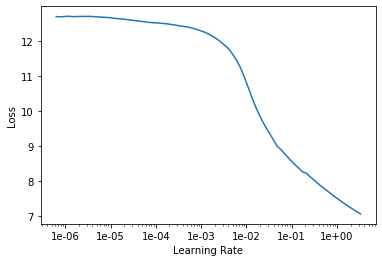

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.056533,0.045481,0.220249,01:10
1,0.019518,0.020014,0.141410,01:39
2,0.012845,0.016931,0.134109,01:44
3,0.009501,0.012679,0.116999,01:35
4,0.008492,0.012431,0.115876,01:37


In [33]:
learn.save('1')

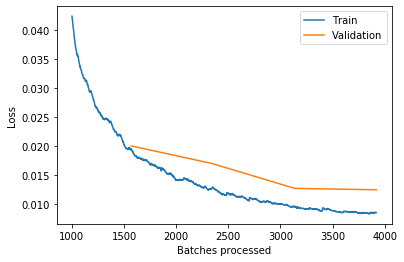

In [36]:
learn.recorder.plot_losses(skip_start=1000)

In [37]:
learn.load('1');

In [38]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.008879,0.013505,0.120674,01:35
1,0.008947,0.013073,0.119840,01:33
2,0.008136,0.011678,0.111397,01:31
3,0.007799,0.011921,0.113588,01:36
4,0.007352,0.011992,0.114216,01:32


In [39]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.007755,0.012924,0.120328,01:17
1,0.008046,0.012659,0.118081,01:48
2,0.007257,0.012472,0.116342,01:31
3,0.006836,0.011803,0.111885,01:42
4,0.006384,0.012034,0.112789,01:39


(10th place in the competition was 0.108)

In [41]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)